In [107]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
from pymc3 import math

# Psychophysics

In [108]:
# Load data frame
psychophysics_df = pd.read_csv('https://github.com/embodied-computation-group/CardioceptionPaper/raw/main/data/Del1_merged.txt')

While the data frame has a lot of columns, here we will mainly analyze `Alpha` (the intensity value) and `Decision` (the response made).

For simplicity, in this exercise, we will only analyze the data from the first participant (`sub_0019`) during the `Extero` condition.n.

In [109]:
this_df = psychophysics_df[(psychophysics_df.Modality == 'Extero') & (psychophysics_df.Subject == 'sub_0019')]

In [110]:
this_df.head()

,Condition,Modality,StairCond,Descision,DecisionRT,Confidence,ConfidenceRT,Alpha,listenBPM,responseBPM,...,StartDecision,ResponseMade,RatingStart,RatingEnds,endTrigger,DecisionRT.1,Decision,TrialType,HeartRateOutlier,Subject
0,Less,Extero,low,Less,1.866683,94.0,0.980083,-40.5,89.5,49.0,...,1.595844e+09,1.595844e+09,1.595844e+09,1.595844e+09,1.595844e+09,1.866683,Less,low,False,sub_0019
1,More,Extero,high,More,1.498754,100.0,1.929751,40.5,54.5,95.0,...,1.595844e+09,1.595844e+09,1.595844e+09,1.595844e+09,1.595844e+09,1.498754,More,high,False,sub_0019
3,More,Extero,high,More,1.866225,61.0,1.295222,20.5,62.5,83.0,...,1.595844e+09,1.595844e+09,1.595844e+09,1.595844e+09,1.595844e+09,1.866225,More,high,False,sub_0019
5,Less,Extero,low,Less,2.648078,66.0,1.529937,-20.5,89.5,69.0,...,1.595844e+09,1.595844e+09,1.595844e+09,1.595844e+09,1.595844e+09,2.648078,Less,low,False,sub_0019
7,Less,Extero,low,Less,2.681985,17.0,1.131664,-0.5,89.0,88.5,...,1.595844e+09,1.595844e+09,1.595844e+09,1.595844e+09,1.595844e+09,2.681985,Less,low,False,sub_0019


Let's take a look at the data. This function will plot the proportion of "Faster" responses depending on the intensity value of the trial stimuli (expressed in BPM). Here, the size of the circle represents the number of trials that were presented for each intensity value.


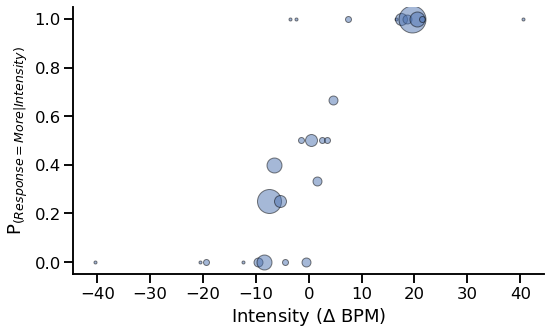

In [111]:
sns.set_context('talk')
fig, axs = plt.subplots(figsize=(8, 5))
for ii, intensity in enumerate(np.sort(this_df.Alpha.unique())):
    resp = sum((this_df.Alpha == intensity) & (this_df.Decision == 'More'))
    total = sum(this_df.Alpha == intensity)
    axs.plot(intensity, resp/total, 'o', alpha=0.5, color='#4c72b0', markeredgecolor='k', markersize=total*3)
plt.ylabel('P$_{(Response = More|Intensity)}$')
plt.xlabel('Intensity ($\Delta$ BPM)')
plt.tight_layout()
sns.despine()

## Exercises

* Create the following figure.

![title](https://github.com/LegrandNico/CognitiveModeling/raw/master/notebooks/data/psychophysics.png)

This figure use the same code as presented above, add a bold blue line representing the most probable psychometric function, and draw 50 grey lines using possible values from the trace generated during model fitting.

The model was defined by:

$$ r_{i} \sim \mathcal{Binomial}(\theta_{i},n_{i})$$
$$ \phi(\theta_{i}) = \frac{1}{2} + \frac{1}{2} * erf(\frac{x_{i} - \alpha}{\beta * \sqrt{2}})$$
$$ \mathcal{i} \mathcal{U}(-40.5, 40.5)$$
$$ \beta \sim  |\mathcal{N}(0, 10)|$$

Where $erf$ denotes the [error functions](https://en.wikipedia.org/wiki/Error_function). The error function is available in the `math` submodule of PyMC3 (see [here](https://docs.pymc.io/api/math.html)).

$\phi$ is the cumulative normal function.

In [112]:
#prep data:
x = this_df.Alpha.values
y = pd.Categorical(this_df.Descision).codes

#Loops that aren't loops:
resp = np.array([sum((this_df.Alpha == intensity) & (this_df.Decision == 'More')) for intensity in np.sort(this_df.Alpha.unique())])
total = np.array([sum(this_df.Alpha == intensity) for intensity in np.sort(this_df.Alpha.unique())])



array([1, 1, 2, 1, 3, 5, 8, 5, 4, 2, 1, 1, 2, 3, 4, 3, 2, 2, 3, 2, 1, 4,
       3, 9, 5, 2, 1])

In [120]:

with pm.Model() as Heimdal:
    #Prior:
    beta = pm.HalfNormal("beta",  10)
    alpha = pm.Normal("alpha", mu = 0, sd = 5)
    #Linear Model:
    phi = pm.Deterministic("phi", 0.5+(0.5*math.erf((total-alpha)/(beta*math.sqrt(2)))))
    #likelihood:
    y_pred = pm.Binomial("y_pred", p = phi, n = total, observed = resp)

    trace = pm.sample(3000, tune = 3000, target_accept = 0.9)

    ### Divergence but plot looks pretty
    


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


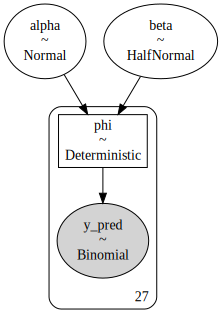

In [114]:
pm.model_to_graphviz(Heimdal)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,-2.245,4.502,-10.913,6.300,0.078,0.056,3320.0,3276.0,3364.0,3222.0,1.0
beta,7.958,6.064,0.003,19.013,0.091,0.065,4412.0,4412.0,2965.0,1925.0,1.0
phi,0.692,0.230,0.329,1.000,0.004,0.003,3403.0,3403.0,3026.0,2839.0,1.0


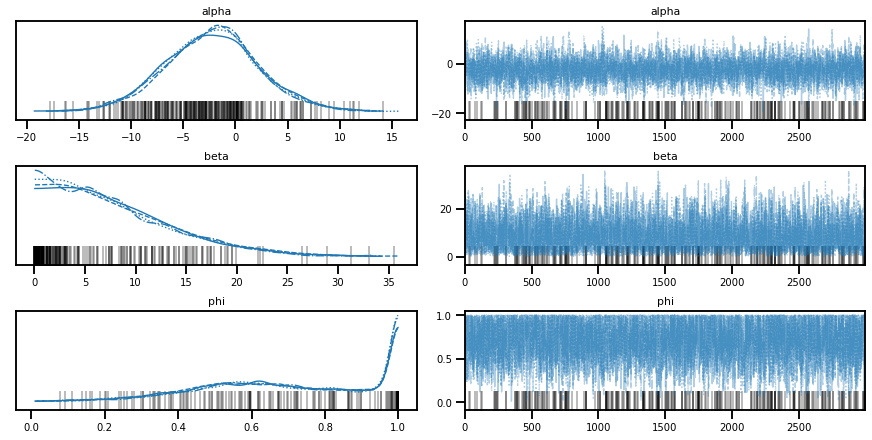

In [121]:
az.plot_trace(trace)
az.summary(trace)

In [122]:
alpha_posterior = trace["alpha"]
beta_posterior = trace["beta"]
#alpha_samples = np.random.choice(alpha_posterior, size = 30)
#beta_samples = np.random.choice(beta_posterior, size = 30)

In [131]:
alpha_samples= alpha_posterior[0:100]
beta_samples= beta_posterior[0:100]

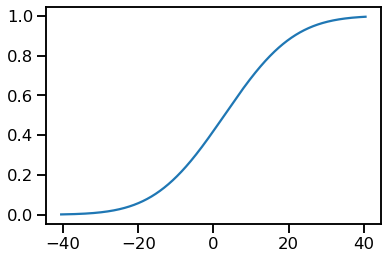

In [117]:
axis = np.linspace(-40.5, 40.5, 1000)
from scipy import stats
plt.plot(axis, stats.norm.cdf(axis, alpha_posterior.mean(), beta_posterior.mean()))

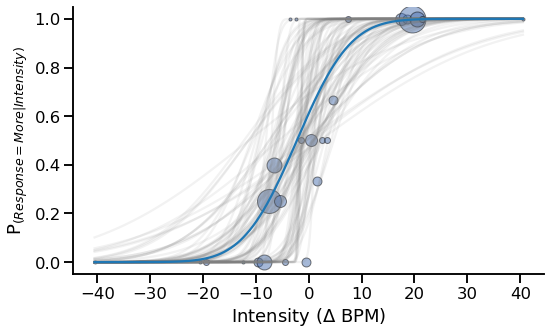

In [132]:

axis = np.linspace(-40.5, 40.5, 1000)

sns.set_context('talk')
fig, axs = plt.subplots(figsize=(8, 5))
for ii, intensity in enumerate(np.sort(this_df.Alpha.unique())):
    resp = sum((this_df.Alpha == intensity) & (this_df.Decision == 'More'))
    total = sum(this_df.Alpha == intensity)
    axs.plot(intensity, resp/total, 'o', alpha=0.5, color='#4c72b0', markeredgecolor='k', markersize=total*3)
for i in range(len(alpha_samples)):
    plt.plot(axis, stats.norm.cdf(axis, alpha_samples[i], beta_samples[i]), alpha=0.1, color="gray")
plt.plot(axis, stats.norm.cdf(axis, alpha_posterior.mean(), beta_posterior.mean()))
plt.ylabel('P$_{(Response = More|Intensity)}$')
plt.xlabel('Intensity ($\Delta$ BPM)')
plt.tight_layout()
sns.despine()
